### Imports

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

### Exploratory Data Analysis (EDA)
   * Concatenating training and testing data for easier preprocessing.
   * Statistical summary of data.
   * Analysing missing value rates.
   * Handling missing values.
   * Visualizing features.
   * Encode categorical features like sex, embarked, etc.
   * Applying log-transformation to normalize the features and git rid of the skew.
   * Using Min-Max to scale the features.

In [81]:
# Loading dataset
train_set = pd.read_csv("titanic.csv")
print("Number of rows in train set:", train_set.shape[0])
test_set = pd.read_csv("test.csv")
test_set.rename(columns={'sibSp': 'sibsp'}, inplace=True) # Fixing feature name to avoid duplication.
print("Number of rows in test set:", test_set.shape[0])

# Concatenating the train and test data
df = pd.concat([train_set, test_set], ignore_index=True)
df["survived"].fillna(0, inplace=True)
df.tail().style.background_gradient(cmap="turbo")

Number of rows in train set: 1309
Number of rows in test set: 19


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
1323,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance Toogood)",female,47.000000,1,0,W.E.P. 5734,61.175000,E31,S,0.000000
1324,2,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.000000,1,0,SC/PARIS 2167,27.720800,nan,C,0.000000
1325,2,"Keane, Mr. Daniel",male,35.000000,0,0,233734,12.350000,nan,Q,0.000000
1326,3,"Assaf, Mr. Gerios",male,21.000000,0,0,2692,7.225000,nan,C,0.000000
1327,3,"Ilmakangas, Miss. Ida Livija",female,27.000000,1,0,STON/O2. 3101270,7.925000,nan,S,0.000000


In [82]:
# Statistical summary
df.describe().T.style.background_gradient(cmap="turbo")

,count,mean,std,min,25%,50%,75%,max
pclass,1328.000000,2.296687,0.836753,1.000000,2.000000,3.000000,3.000000,3.000000
age,1064.000000,29.927788,14.413728,0.166700,21.000000,28.000000,39.000000,80.000000
sibsp,1328.000000,0.499247,1.036631,0.000000,0.000000,0.000000,1.000000,8.000000
parch,1328.000000,0.381024,0.860768,0.000000,0.000000,0.000000,0.000000,9.000000
fare,1327.000000,33.106063,51.464510,0.000000,7.895800,14.454200,31.137500,512.329200
survived,1328.000000,0.376506,0.484692,0.000000,0.000000,0.000000,1.000000,1.000000


In [83]:
# Analysing missing value rates
for col in df.columns:
    print(f"{col} missing value rate: {round(df[col].isnull().sum() * 100 / len(df),2)}%")

# Correlation between "age" and the target label "survived"
print(f"\nCorrelation between passenger age and their survival status: {round(df['age'].corr(df['survived']), 3)}")

pclass missing value rate: 0.0%
name missing value rate: 0.0%
sex missing value rate: 0.0%
age missing value rate: 19.88%
sibsp missing value rate: 0.0%
parch missing value rate: 0.0%
ticket missing value rate: 0.0%
fare missing value rate: 0.08%
cabin missing value rate: 77.64%
embarked missing value rate: 0.15%
survived missing value rate: 0.0%

Correlation between passenger age and their survival status: -0.057


### Findings based on analysis
   * Four columns have missing data: age, fare, cabin, embarked
      * We can handel the "fare" and "embarked columns by dropping the rows with missing value since they represent less than 1% of our data.
      * For the "cabin" column, more than 75% of the values are missing. So, there is really nothing we can do for that column but drop it.
      * As for the "age" column, its correlation to the target variable is very low at - 0.056, implying that it's safe to drop that column.

In [84]:
# Handling missing values
# Drop columns with high missing-value rates
df.drop(columns=["cabin"], inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

print("Number of rows:", df.shape[0])

Number of rows: 1061


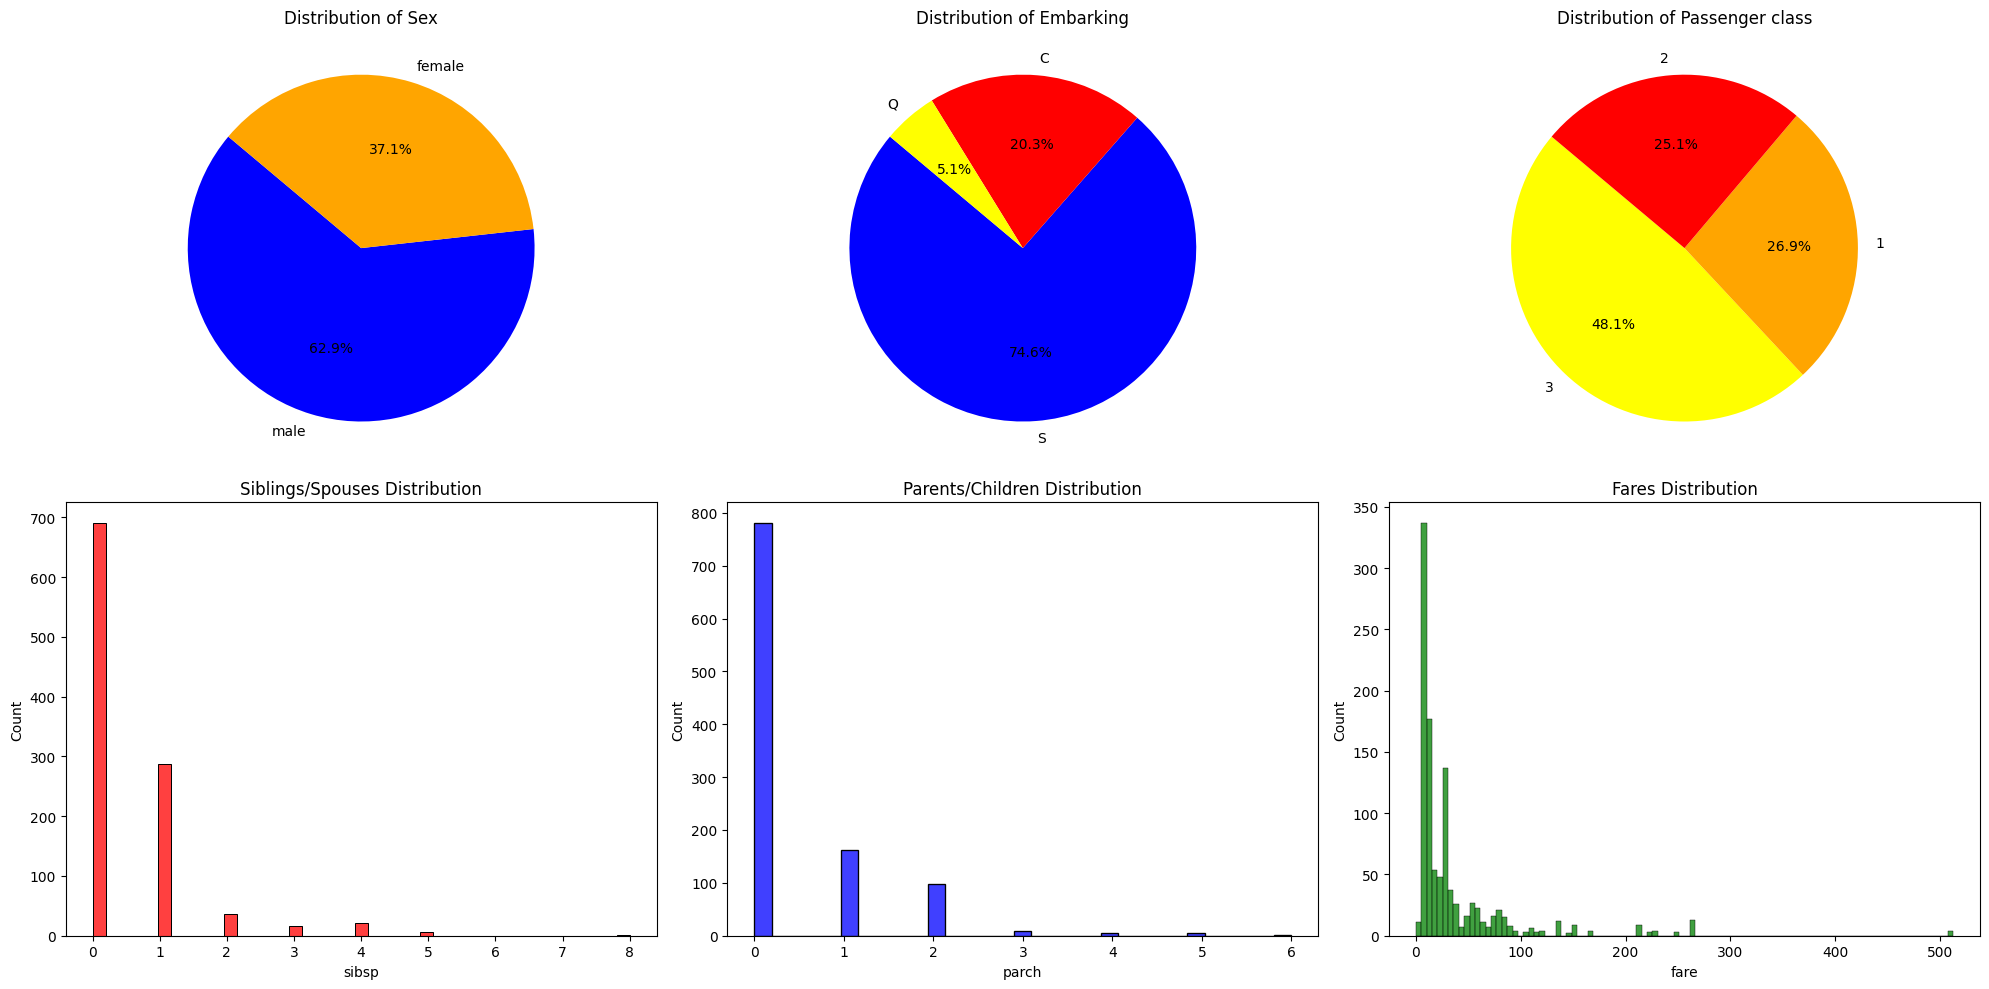

In [85]:
# Visualizing features
axes = plt.subplots(2, 3, figsize=(20, 10))[1]

# Sex Distribution
sex_counts = df['sex'].value_counts(normalize=True)
axes[0, 0].pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'orange'])
axes[0, 0].set_title('Distribution of Sex')

# Embarked Distribution
embarked_counts = df['embarked'].value_counts(normalize=True)
axes[0, 1].pie(embarked_counts, labels=embarked_counts.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'red', 'yellow'])
axes[0, 1].set_title('Distribution of Embarking')

# Passenger class Distribution
pclass_counts = df['pclass'].value_counts(normalize=True)
axes[0, 2].pie(pclass_counts, labels=pclass_counts.index, autopct='%1.1f%%', startangle=140, colors=['yellow', 'orange', 'red'])
axes[0, 2].set_title('Distribution of Passenger class')

# Siblings/Spouses Distribution
sns.histplot(df['sibsp'], ax=axes[1, 0], color='red')
axes[1, 0].set_title('Siblings/Spouses Distribution')

# Parents/Children Distribution
sns.histplot(df['parch'], ax=axes[1, 1], color='blue')
axes[1, 1].set_title('Parents/Children Distribution')

# Fares Distribution
sns.histplot(df['fare'], ax=axes[1, 2], color='green')
axes[1, 2].set_title('Fares Distribution')

plt.tight_layout()
plt.show()

In [86]:
# Encoding categorical features
df = pd.concat([df, pd.get_dummies(df['sex'], prefix='sex')], axis=1)
df.drop('sex', axis=1, inplace=True)
df = pd.concat([df, pd.get_dummies(df['embarked'], prefix='embarked')], axis=1)
df.drop('embarked', axis=1, inplace=True)

df.head().style.background_gradient(cmap="turbo")

,pclass,name,age,sibsp,parch,ticket,fare,survived,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,"Allen, Miss. Elisabeth Walton",29.000000,0,0,24160,211.337500,1.000000,True,False,False,False,True
1,1,"Allison, Master. Hudson Trevor",0.916700,1,2,113781,151.550000,1.000000,False,True,False,False,True
2,1,"Allison, Miss. Helen Loraine",2.000000,1,2,113781,151.550000,0.000000,True,False,False,False,True
3,1,"Allison, Mr. Hudson Joshua Creighton",30.000000,1,2,113781,151.550000,0.000000,False,True,False,False,True
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.000000,1,2,113781,151.550000,0.000000,True,False,False,False,True


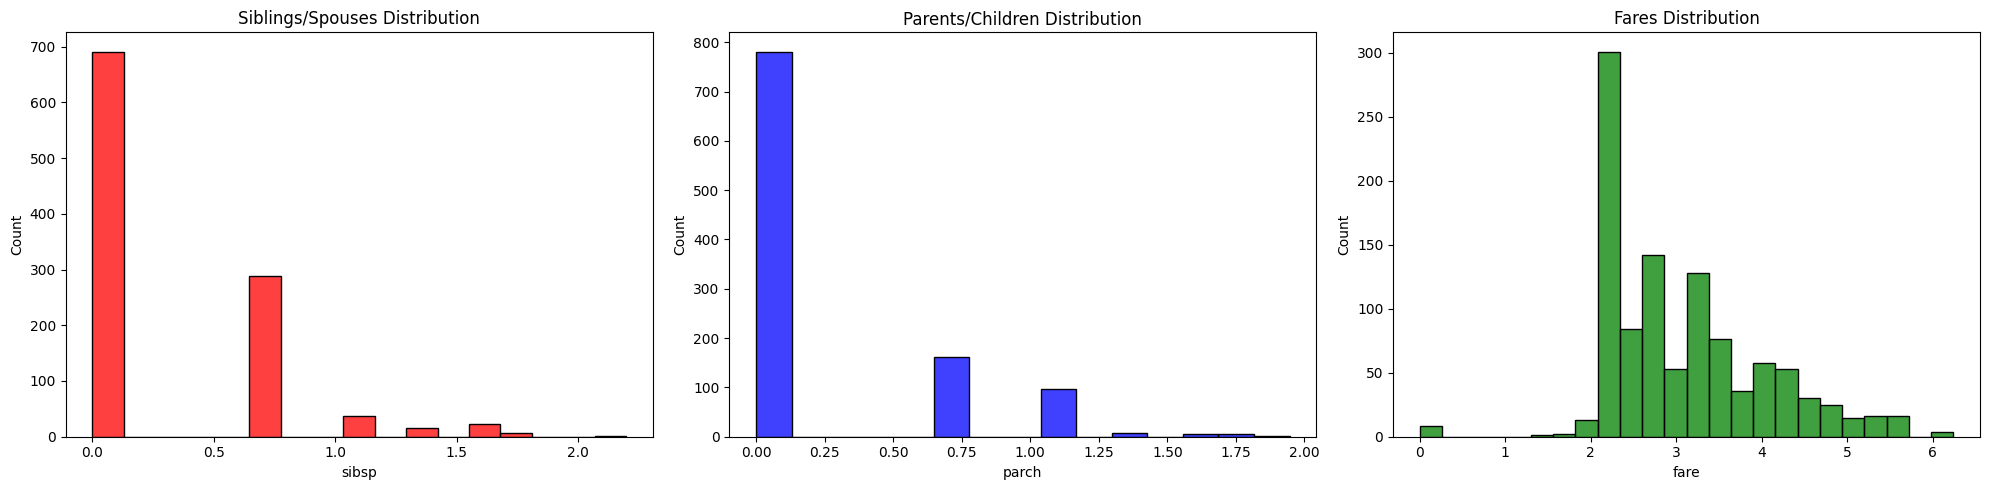

In [87]:
# Apply log transformation to 'fare', 'parch', and 'sibsp' columns
df['fare'] = np.log(df['fare'] + 1)
df['parch'] = np.log(df['parch'] + 1)
df['sibsp'] = np.log(df['sibsp'] + 1)
df['age'] = np.log(df['age'] + 1)

axes = plt.subplots(1, 3, figsize=(20, 5))[1]

# Siblings/Spouses Distribution
sns.histplot(df['sibsp'], ax=axes[0], color='red')
axes[0].set_title('Siblings/Spouses Distribution')

# Parents/Children Distribution
sns.histplot(df['parch'], ax=axes[1], color='blue')
axes[1].set_title('Parents/Children Distribution')

# Fares Distribution
sns.histplot(df['fare'], ax=axes[2], color='green')
axes[2].set_title('Fares Distribution')

plt.tight_layout()
plt.show()

In [88]:
# Scaling features
scaler = MinMaxScaler()
df[['fare', 'parch', 'sibsp', 'pclass', 'age']] = scaler.fit_transform(df[['fare', 'parch', 'sibsp', 'pclass', 'age']])

In [89]:
# Splitting the data back to train and test sets
test_set = df.tail(19).copy()
test_set.drop(["survived"], axis=1, inplace=True)
df = df.iloc[:-19]
test_set.head().style.background_gradient(cmap="turbo")

,pclass,name,age,sibsp,parch,ticket,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
1308,1.000000,"Zimmerman, Mr. Leo",0.765757,0.000000,0.000000,315082,0.349827,False,True,False,False,True
1309,1.000000,"Kelly, Mr. James",0.805457,0.000000,0.000000,330911,0.348997,False,True,False,True,False
1310,1.000000,"Wilkes, Mrs. James (Ellen Needs)",0.876600,0.315465,0.000000,363272,0.333195,True,False,False,False,True
1311,0.500000,"Myles, Mr. Thomas Francis",0.940732,0.000000,0.000000,240276,0.379604,False,True,False,True,False
1312,1.000000,"Wirz, Mr. Albert",0.749487,0.000000,0.000000,315154,0.363449,False,True,False,False,True


In [90]:
df.head().style.background_gradient(cmap="turbo")

,pclass,name,age,sibsp,parch,ticket,fare,survived,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,0.000000,"Allen, Miss. Elisabeth Walton",0.765757,0.000000,0.000000,24160,0.858556,1.000000,True,False,False,False,True
1,0.000000,"Allison, Master. Hudson Trevor",0.117074,0.315465,0.564575,113781,0.805569,1.000000,False,True,False,False,True
2,0.000000,"Allison, Miss. Helen Loraine",0.222729,0.315465,0.564575,113781,0.805569,0.000000,True,False,False,False,True
3,0.000000,"Allison, Mr. Hudson Joshua Creighton",0.773490,0.315465,0.564575,113781,0.805569,0.000000,False,True,False,False,True
4,0.000000,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0.732009,0.315465,0.564575,113781,0.805569,0.000000,True,False,False,False,True


In [91]:
# Splitting the data into features and target variable
X = df.drop(["survived", "name", "ticket"], axis=1)  # Features
y = df["survived"]  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Naive Bayes
   * Checking dataset for imbalance between labels.
   * Training the model on the training set.
   * Performing cross-validation.
   * Evaluating the model using different metrics and visualizing the results.
   * Predicting survival status of new examples in the test set.

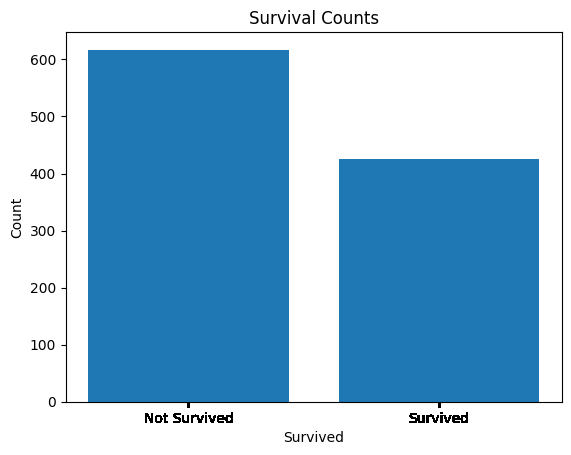

In [92]:
# Check if the dataset is balanced
survived_counts = df['survived'].map({1: 'Survived', 0: 'Not Survived'}).value_counts()
plt.bar(survived_counts.index, survived_counts.values)

plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Survival Counts')
plt.xticks(df['survived'].map({1: 'Survived', 0: 'Not Survived'}))

plt.show()

In [93]:
# Train Naive Bayes Classifier
nb_classifier = GaussianNB()

# Perform cross-validation
cv_scores = cross_val_score(nb_classifier, X, y, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)

Cross-validation scores: [0.49760766 0.87559809 0.80769231 0.74519231 0.65384615]
Mean accuracy: 0.7159873021715126


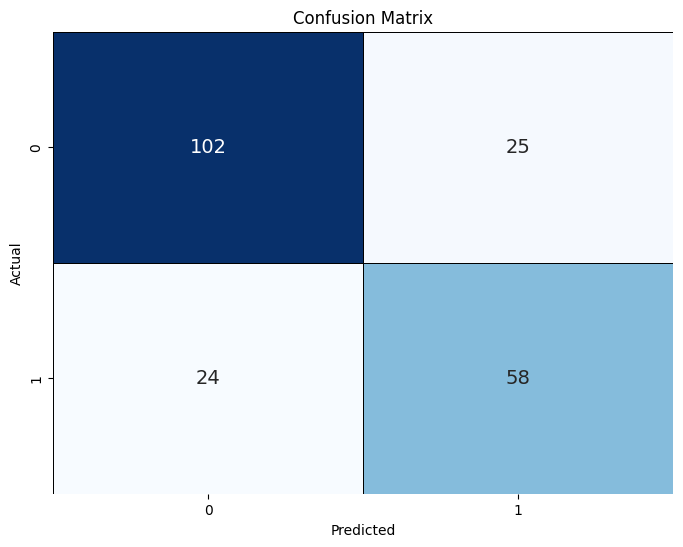


Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.80      0.81       127
         1.0       0.70      0.71      0.70        82

    accuracy                           0.77       209
   macro avg       0.75      0.76      0.75       209
weighted avg       0.77      0.77      0.77       209



In [94]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
true_negative = conf_matrix[0][0]
false_positive = conf_matrix[0][1]
false_negative = conf_matrix[1][0]
true_positive = conf_matrix[1][1]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"fontsize": 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [95]:
# Predicting survival status of new data

test_set['nb_survived'] = nb_classifier.predict(test_set.drop(['name', 'ticket'], axis=1)).astype(int)
test_set[['name', 'nb_survived']].style.background_gradient(cmap="turbo")

,name,nb_survived
1308,"Zimmerman, Mr. Leo",0
1309,"Kelly, Mr. James",0
1310,"Wilkes, Mrs. James (Ellen Needs)",1
1311,"Myles, Mr. Thomas Francis",0
1312,"Wirz, Mr. Albert",0
1313,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1
1314,"Svensson, Mr. Johan Cervin",0
1315,"Connolly, Miss. Kate",0
1316,"Caldwell, Mr. Albert Francis",0
1317,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1


### Support Vector Machine (SVM)
* Checking dataset for imbalance between labels.
* Training the model on the training set.
* Performing cross-validation.
* Evaluating the model using different metrics and visualizing the results.
* Predicting survival status of new examples in the test set.

In [96]:
from sklearn import svm

# Train SVM classifier
svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)

SVC()

In [97]:
# Perform cross-validation
cv_scores = cross_val_score(svm_classifier, X, y, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.50717703 0.83253589 0.82211538 0.73557692 0.62980769]
Mean accuracy: 0.7054425837320574


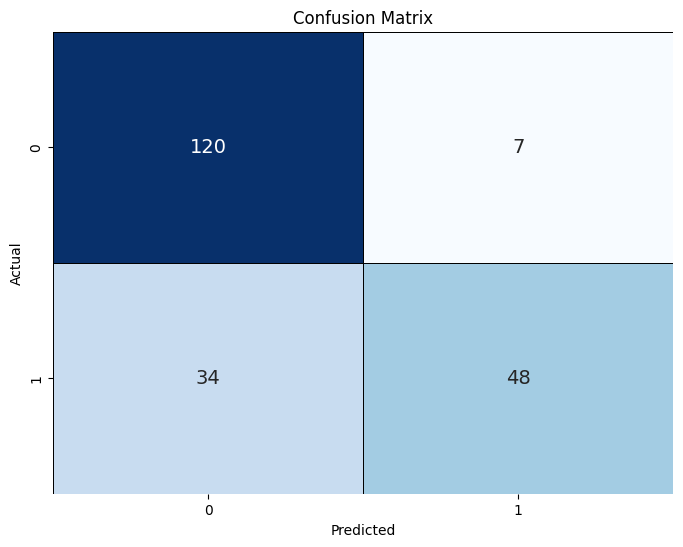


Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.94      0.85       127
         1.0       0.87      0.59      0.70        82

    accuracy                           0.80       209
   macro avg       0.83      0.77      0.78       209
weighted avg       0.82      0.80      0.79       209



In [98]:
# Make predictions
y_pred_svm = svm_classifier.predict(X_test)

# Compute confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"fontsize": 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

In [99]:
test_set.drop(['nb_survived'], axis=1, inplace=True)
test_set['svm_survived'] = svm_classifier.predict(test_set.drop(['name', 'ticket'], axis=1)).astype(int)
test_set[['name', 'svm_survived']].style.background_gradient(cmap="turbo")

,name,svm_survived
1308,"Zimmerman, Mr. Leo",0
1309,"Kelly, Mr. James",0
1310,"Wilkes, Mrs. James (Ellen Needs)",0
1311,"Myles, Mr. Thomas Francis",0
1312,"Wirz, Mr. Albert",0
1313,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0
1314,"Svensson, Mr. Johan Cervin",0
1315,"Connolly, Miss. Kate",0
1316,"Caldwell, Mr. Albert Francis",0
1317,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1


### K-Nearest Neighbors (KNN)
* Checking dataset for imbalance between labels.
* Training the model on the training set.
* Performing cross-validation.
* Evaluating the model using different metrics and visualizing the results.
* Predicting survival status of new examples in the test set.

In [100]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [101]:
# Perform cross-validation
cv_scores = cross_val_score(knn_classifier, X, y, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.50717703 0.70813397 0.74038462 0.75       0.62980769]
Mean accuracy: 0.6671006624953992


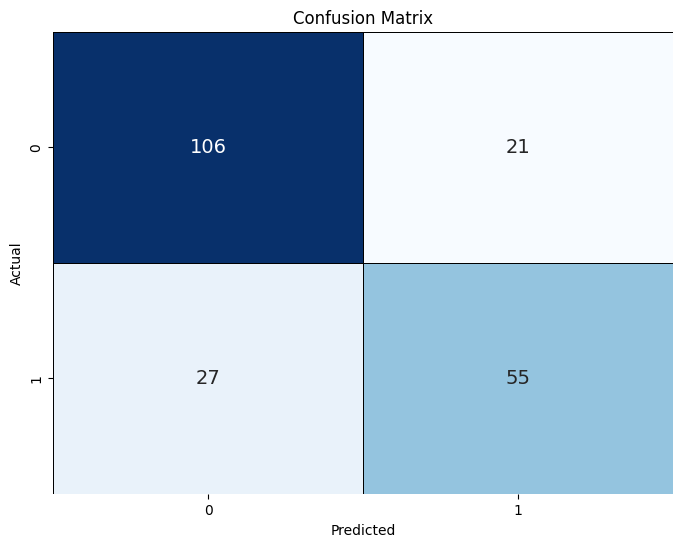


Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.83      0.82       127
         1.0       0.72      0.67      0.70        82

    accuracy                           0.77       209
   macro avg       0.76      0.75      0.76       209
weighted avg       0.77      0.77      0.77       209



In [102]:
# Make predictions
y_pred_knn = knn_classifier.predict(X_test)

# Compute confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"fontsize": 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

In [103]:
# Predicting survival status of new data
test_set.drop(['svm_survived'], axis=1, inplace=True)
test_set['knn_survived'] = knn_classifier.predict(test_set.drop(['name', 'ticket'], axis=1)).astype(int)
test_set[['name', 'knn_survived']].style.background_gradient(cmap="turbo")

,name,knn_survived
1308,"Zimmerman, Mr. Leo",0
1309,"Kelly, Mr. James",0
1310,"Wilkes, Mrs. James (Ellen Needs)",0
1311,"Myles, Mr. Thomas Francis",0
1312,"Wirz, Mr. Albert",0
1313,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1
1314,"Svensson, Mr. Johan Cervin",0
1315,"Connolly, Miss. Kate",0
1316,"Caldwell, Mr. Albert Francis",0
1317,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1
